In [5]:
!pip install stable_baselines3


  Using cached stable_baselines3-2.7.1-py3-none-any.whl.metadata (4.8 kB)
INFO: pip is looking at multiple versions of stable-baselines3 to determine which version is compatible with other requirements. This could take a while.
  Using cached stable_baselines3-2.7.0-py3-none-any.whl.metadata (4.8 kB)
  Using cached stable_baselines3-2.6.0-py3-none-any.whl.metadata (4.8 kB)
  Using cached gymnasium-1.1.1-py3-none-any.whl.metadata (9.4 kB)
  Using cached stable_baselines3-2.5.0-py3-none-any.whl.metadata (4.8 kB)
  Using cached gymnasium-1.0.0-py3-none-any.whl.metadata (9.5 kB)
  Using cached stable_baselines3-2.4.1-py3-none-any.whl.metadata (4.5 kB)
  Using cached numpy-1.26.4.tar.gz (15.8 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... one
^C
anceled
ERROR: Operation cancelled by user


C:\Users\srime\AppData\Local\Temp\ipykernel_30184\1856420071.py:34: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  }).resample("Q").mean().dropna()


1980-01-01    0.206962
1980-04-01   -2.411866
1980-07-01   -2.990332
1980-10-01   -1.673680
1981-01-01   -0.067246
                ...   
2009-01-01   -4.410330
2009-04-01   -4.950392
2009-07-01   -4.963565
2009-10-01   -4.273767
2010-01-01   -4.147804
Length: 121, dtype: float64
1981-03-31    16.570000
1981-06-30    17.780000
1981-09-30    17.576667
1981-12-31    13.586667
1982-03-31    14.226667
                ...    
2009-03-31     0.183333
2009-06-30     0.180000
2009-09-30     0.156667
2009-12-31     0.120000
2010-03-31     0.110000
Freq: QE-DEC, Name: interest, Length: 117, dtype: float64


<Figure size 640x480 with 0 Axes>

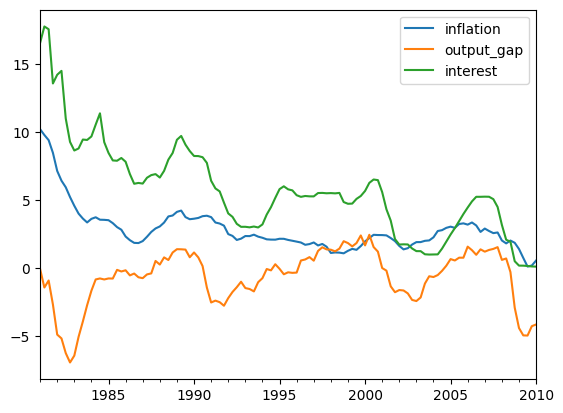

In [66]:
#Fred data extraction
#basically to train our rl model, we need to know how inflation rate can be predicted based on time passed/prior inflation rate
#we will also need to do the same for the output gap
#so we will need to train on the ANN 

#This cell is for data extraction, We will be getting inflation/out put gap data

from fredapi import Fred
import pandas as pd
import matplotlib.pyplot as plt

fred = Fred(api_key="INSERT KEY HERE")


#to get inflation data we will use GDPDEF (gdp deflator) and calculate percent change from year to year which tracks inflation across consumer goods

gdp_deflator = fred.get_series("GDPDEF", "1980-01-01", "2010-01-01")
inflation = gdp_deflator.pct_change(periods=4)*100

#to get output gap data we will use GDPC1 and GDPPOT and subtract and divide by GDPPOT to get the output gap percentage

rgdp = fred.get_series("GDPC1", "1980-01-01", "2010-01-01")
pgdp = fred.get_series("GDPPOT", "1980-01-01", "2010-01-01")
output_gap = ((rgdp - pgdp) / pgdp) * 100

#to get interest rate we will use the federal funds rate FEDFUNDS
interest=fred.get_series("FEDFUNDS", "1980-01-01", "2010-01-01")

#this reorgnaizes data into quarterly segments 
data = pd.DataFrame({
    "inflation":inflation,
    "output_gap":output_gap,
    "interest":interest
}).resample("Q").mean().dropna()

plt.figure()

data.plot()

#there are 121 values (for both)
print(output_gap)
print(data["interest"])

In [10]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd



In [78]:
#Basic ANN code with scikit so that a neural network can use forward-propagation to predict future inflation/output gap 
#based on past data
#using https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html

def skmodel (x, y, hidden):
    #Split data into train and test

    x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.85, test_size=0.15)  
    model = MLPRegressor(
        hidden_layer_sizes=(hidden,),  
        activation='tanh', # Tanh activation from deustche paper
        solver='lbfgs',                  
        max_iter=10000,
        early_stopping=True,
        n_iter_no_change=6,             
        random_state=42,
        verbose=True
    )

    model.fit(x_train, y_train)
    train_score = model.score(x_train,y_train)
    test_score = model.score(x_test,y_test)
    print(train_score)
    print(test_score)

    #we need the weights and biases to use in our other model to calculate the transition equstion
    parameters = {"hidden_weights":model.coefs_[0].T, "hidden_biases":model.intercepts_[0], "output_weights":model.coefs_[1].flatten(),'output_bias': model.intercepts_[1][0]}
    return model, parameters

#this is wrong I need to use the "previous" inputs to find a relation between the current inflation and past inflation/og/interestrate
# inflation_data = data["inflation"]
# inflation_new = []
# listappendix = []
# outputnew= []
# outputdata=data["inflation"]

# for i in range(len(data["inflation"])):
#     inflation_new.append(inflation_data[i].item())
#     listappendix.append(i+1)

# for i in range(len(data["inflation"])):
#     outputnew.append(outputdata[i].item())

# print(inflation_new)

# skmodel(listappendix,inflation,3)
# # skmodel(listappendix,,4)

def training_data(data):
    #load the three values
    y= data["output_gap"].values
    pi = data["inflation"].values
    i = data["interest"].values

    x_output=[]
    x_inflation=[]
    y_output=[]
    y_inflation=[]
    for z in range(len(y)-3):
        #here we are adding previous values so that we can make inferences based off of them
        #our current "state" would be y[i+2]/pi[i+2]
        #so this one would be missing a y[i+2] since that goes in the y_output
        x_output.append([y[z],y[z+1],pi[z],pi[z+1],pi[z+2],i[z],i[z+1],i[z+2]])
        #this one would be missing a pi[i+2] since that goes in the y_inflaiton
        x_inflation.append([y[z],y[z+1],y[z+2],pi[z],pi[z+1],i[z],i[z+1],i[z+2]])
        y_output.append([y[z+2]])
        y_inflation.append([pi[z+2]])
    print(x_output)
    print(x_inflation)
    print(y_output)
    print(y_inflation)
    return (np.array(x_output),np.array(y_output)), (np.array(x_inflation),np.array(y_inflation))

(x_output, y_output), (x_inflation, y_inflation) = training_data(data)
output_model, output_params = skmodel(x_output, y_output, 3)
inflation_model, inflation_params = skmodel(x_inflation, y_inflation, 3)
#we will need the parameters for our rl mode
print(output_params)

#our current model now has 93%/96% test accuracy


[[np.float64(-0.06724591709963097), np.float64(-1.4279916122253107), np.float64(10.220783663587806), np.float64(9.793085721629623), np.float64(9.415698697641673), np.float64(16.569999999999997), np.float64(17.78), np.float64(17.576666666666664)], [np.float64(-1.4279916122253107), np.float64(-0.9117341930154639), np.float64(9.793085721629623), np.float64(9.415698697641673), np.float64(8.480764518500372), np.float64(17.78), np.float64(17.576666666666664), np.float64(13.586666666666666)], [np.float64(-0.9117341930154639), np.float64(-2.680901407836747), np.float64(9.415698697641673), np.float64(8.480764518500372), np.float64(7.150531216425948), np.float64(17.576666666666664), np.float64(13.586666666666666), np.float64(14.226666666666667)], [np.float64(-2.680901407836747), np.float64(-4.892555438737442), np.float64(8.480764518500372), np.float64(7.150531216425948), np.float64(6.433337235163283), np.float64(13.586666666666666), np.float64(14.226666666666667), np.float64(14.513333333333334)]

C:\Users\srime\anaconda3\envs\econv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1771: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.9379661509111178
0.9355701528843345


C:\Users\srime\anaconda3\envs\econv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1771: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.983331971951726
0.964426365310608
{'hidden_weights': array([[ 0.05954455,  0.53202837, -1.24440495, -0.25909979, -0.06520716,
        -0.74953505, -0.36895772, -0.72846339],
       [ 1.13465551,  0.37383468,  0.10650877, -1.05940109, -0.65024526,
        -0.59193555, -0.42439115, -0.35120619],
       [ 0.03475356, -0.16472553, -0.02808763,  0.06947031, -0.01752077,
         0.02336486,  0.01332844, -0.04442171]]), 'hidden_biases': array([-0.36937569,  0.17358081, -0.40670848]), 'output_weights': array([ 0.83526611,  0.93299065, -7.47515555]), 'output_bias': np.float64(-0.9030018921978882)}


In [94]:
#now we will implement these models into our rl model as transition equations
#the weights of the model 
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import stable_baselines3 as sb

In [109]:
#notes for myself
#what we are trying to change is the interest rate
#observe its effects on the inflation pi and output gap y
#reward should minimize the inflation and output gap y with the taylor equation
#beta = discount factor so how much current inflation affects future inflation
#alpha = slope of phillips curve , positive alpha means larger outputgap = higiher inflation
#so what i need to do is evaluate the next action (forward looking) in my step function 
#evlauting this next action means that prior  "states" need to be considered in the rl process
#this means to make the problem markovian, i must put these all in the observation space
#with the ann(neural net) transition parameters for interest rate and output gap 
#i will start by using q2 2025 usa data for my model (initial values)
class Econov(gym.Env):

    def __init__(self, alpha=0.99):
        #alpha is the discount factor
        self.alpha=alpha
        # self.beta=beta


        self.max_steps = 4000
        self.steps = 0
        
        #initial values are baesd upon q1/q2 2025 fed data and september/august 2025 inflation rate
        self.pi_0 = 2.90
        self.pi_1 = 3.0
        self.y_0 = 13.19
        self.y_1 = 13.74
        
        #setting ideal values of pi and y according to the fed
        self.pi_goal = 2.0
        self.y_goal =0.0
        
        #this is the variable that we want to adjust so we can choose it randomly and we have a zero lower bound
        self.i_0 = np.random.uniform(0.0,20.0)
        self.i_1 = np.random.uniform(0.0,20.0)
        
        #sets limits for the range of values so that rl model doesnt "cheat" the system, we are using values that within a somewhat reasonable range
        self.pi_min = -2.0
        self.y_min = -20.0
        self.i_min = -2.0
        self.y_max = 20.0
        self.pi_max = 10.0
        self.i_max= 20.0 
        self.values = {"inflation":[self.pi_0,self.pi_1], "output_gap":[self.y_0,self.y_1], "interest_rate":[self.i_0,self.i_1]}
        self.low = np.array([self.pi_min, self.y_min], dtype= np.float32)
        self.high = np.array([self.pi_max, self.y_max], dtype= np.float32)
        
        #setting up action space and observation continous spaces so that we can do policy based rl
        self.action_space = spaces.Box(low=self.i_min, high=self.i_max, shape=(1,), dtype=np.float32)
        #order is pi_1, pi_2 y_1 y_2
        self.observation_space = spaces.Box(low=np.array([self.pi_min, self.pi_min, self.y_min, self.y_min]), high=np.array([self.pi_min, self.pi_min, self.y_min, self.y_min]), shape=(4,), dtype=np.float32)
        
        #reset before running
        self.reset()

    def step(self, action):
        #we will define pi_1, y_1, and i_1 as current(even though they technically arent) so that we can use the pi, y, i values to determine transition equations values
        self.pi, self.pi_1, self.y, self.y_1 = self.state

        #we alr have the action space so it is constrained by that
        self.i = action[0]

        #get the previously stored values
        self.pi_1=self.values["inflation"][-1]
        self.pi_2=self.values["inflation"][-2]
        try:
            print(self.values["inflation"][-3])
            self.pi_3 = self.values["inflation"][-3]
        except:
            
            #old rate plus some random error
            self.pi_3 = self.pi_2+np.random.uniform[0.0,1.0]
            
        self.i_1=self.values["interest_rate"][-1]
        self.i_2=self.values["interest_rate"][-2]
        self.y_1=self.values["output_gap"][-1]
        self.y_2=self.values["output_gap"][-2]
        
        #we dont have a value of pi yet so we will have to just go one more step back 
        output_gap_inputs=np.array([self.y_1, self.y_2, self.pi_1, self.pi_2, self.pi_3, self.i, self.i_1, self.i_2])
        self.y = transition(output_params, output_gap_inputs)
        inflation_inputs=np.array([self.y, self.y_1, self.y_2, self.pi_1, self.pi_2, self.i, self.i_1, self.i_2])
        self.pi = transition(inflataion_params, inflation_inputs)

        #append new values to history
        self.values["inflation"].append(self.pi)
        self.values["output_gap"].append(self.y)
        self.values["interest_rate"].append(self.i)
        
        #equal weight with okuns law usuallly means 0.125 but studie show that both are equal to improve social welfare
        w=0.5
        self.reward = -w*(self.pi - self.pi_goal)**2-w*(self.y)
        self.steps+= 1

        self.observation = np.array([self.pi, self.pi_1, self.y, self.y_1], dtype=np.float32)
        
        truncated = 1.7 <= pi <= 2.3 and -0.3 <= y <= 0.3
        terminated = steps >= self.max_steps
        info = {"y":self.y, "pi":self.pi, "i":self.i, "reward":self.reward}
        
        return observation, reward, truncated, terminated, info
        
    def transition(params, inputs):
        
        hidden_inputs = np.dot(params["hidden_weights"], inputs)+params["hidden_biases"]
        #our ann has one tanh layer
        hidden_outputs = np.tanh(hidden_inputs)
        
        output = params["output_bias"] + np.dot(params["output_weights"],hidden_outputs)
        
        #return with some noise
        return output + np.random.uniform(0.0,1.0)

    def reset():
        super().reset()
        self.pi_0 = 2.90
        self.pi_1 = 3.0
        self.y_0 = 13.19
        self.y_1 = 13.74
        self.i_0 = np.random.uniform(0.0,20.0)
        self.i_1 = np.random.uniform(0.0,20.0)
        self.values = {"inflation":[self.pi_0,self.pi_1], "output_gap":[self.y_0,self.y_1], "interest_rate":[self.i_0,self.i_1]}
        self.steps = 0
        self.observation = np.array([self.pi_0, self.pi_1, self.y_0, self.y_1], dtype=np.float32)
        self.info = {"y":self.y_1, "pi":self.pi_1, "i":self.i_1}
        return observation, info


In [111]:
#we will use a ddpg algo to train the rl
from stable_baselines3 import DDPG, TD3, SAC
from stable_baselines3.common.noise import NormalActionNoise

env=Econov()
n_actions = env.action_space.shape[0]
action_noise = NormalActionNoise(
    mean=np.zeros(n_actions), 
    sigma=0.5*np.ones(n_actions)
)
    
model = DDPG(
    "MlpPolicy",
    env,
    action_noise=action_noise,
    learning_rate=1e-3,
    buffer_size=100000,
    learning_starts=1000,
    batch_size=256,
    gamma=0.99,
    tau=0.005,
    verbose=1
)
    
# Train the agent
print("Training")
model.learn(total_timesteps=500000)

TypeError: Econov.reset() takes 0 positional arguments but 1 was given